In [2]:
from pathlib import Path
import numpy as np
import pandas as pd

## Prepare Data

In [ ]:
sfreq = 512
tmin = -0.2
rows = []

windows = {
    "early": (0.05, 0.15),
    "mid":   (0.15, 0.35),
    "late":  (0.35, 0.80),
}

for fname in Path("data/labels/").glob("*_labels.npz"):
    subj, movie, order, _ = fname.stem.split("_", 3)
    subj = int(subj)

    npz = np.load(fname)
    X = npz[npz.files[0]]  # (epochs, rois, times)
    if X.ndim != 3:
        raise ValueError(f"{fname.name}: expected (epochs, rois, times), got {X.shape}")

    n_epochs, n_rois, n_times = X.shape
    times = np.arange(n_times) / sfreq + tmin
    assert np.isclose(times[0], tmin)

    for win, (t0, t1) in windows.items():
        tmask = (times >= t0) & (times < t1)
        if not np.any(tmask):
            raise ValueError(f"{fname.name}: window {win} empty")

        feat = X[:, :, tmask].mean(axis=-1)

        rows.append(pd.DataFrame({
            "subject": subj,
            "movie": movie,
            "condition": order,
            "epoch": np.repeat(np.arange(n_epochs), n_rois),
            "roi": np.tile(np.arange(n_rois), n_epochs),
            "window": win,
            "t_start": t0,
            "t_end": t1,
            "amplitude": feat.reshape(-1),
        }))

df = pd.concat(rows, ignore_index=True)

## Statistical analysis

## Visualisation

In [23]:
file_name = '01-art_nl'
labels = np.load(f'data/labels/{file_name}-labels.npz')
evoked_A = labels['labels']

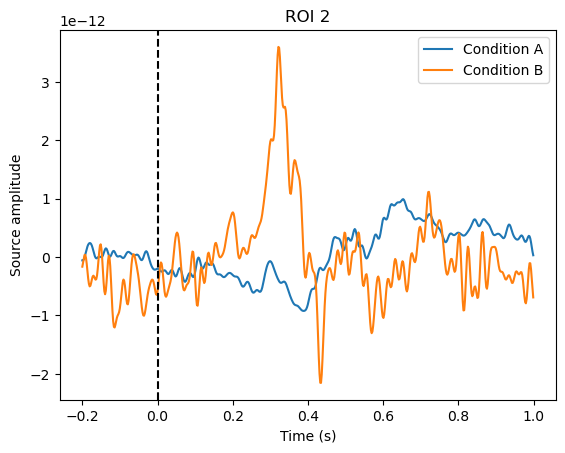

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# shapes: (n_sub, n_rois, n_times)
GA_A = evoked_A.mean(axis=0)
GA_B = evoked_B.mean(axis=0)

times = np.arange(GA_A.shape[-1]) / sfreq - 0.2
roi = 2

plt.plot(times, GA_A[roi], label="Condition A")
plt.plot(times, GA_B[roi], label="Condition B")
plt.axvline(0, color="k", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("Source amplitude")
plt.legend()
plt.title(f"ROI {roi}")
plt.show()
